### **Data cleaning**

Note: When lacking of packages, just use "!pip install ..."

In [1]:
import pandas as pd
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geopandas as gpd
from esda.moran import Moran
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
from zipfile import ZipFile
import os
import shutil
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pyecharts import Map
import re

The urls that needed

In [2]:
night_economy_url = "https://data.london.gov.uk/download/london-night-time-economy/e554ddcd-4fb7-42dc-b0d2-d73f88938cdb/night-time-economy.xls"
late_night_liscenses_url = "https://data.london.gov.uk/download/alcohol-and-late-night-refreshment-licensing-statistics/7836522b-3b4c-4aae-9aa3-9b2389621a96/licensed-premises-24-hour.xlsx"
inside_airbnb_url = 'http://data.insideairbnb.com/united-kingdom/england/london/2022-12-10/visualisations/listings.csv'
land_url = 'https://data.london.gov.uk/download/land-area-and-population-density-ward-and-borough/cc4e7e08-3071-488f-bdd9-a62cb1ed1c5c/land-area-population-density-london.xlsx'

Data cleaning for the **Night Time Economy** dataset

The dataset after cleaning should contain information about numbers of employees and workplaces in:
1. Cultural and leisure activities
2. Activities which support night time cultural and leisure activities
3. 24-hour health and personal social services
4. Activities which support wider social and economic activities
5. Any Night Time Economy category
6. Total in all sectors

In [3]:
# read in different data from different sheets
df_night_employee_all = pd.read_excel(night_economy_url, sheet_name='NTE employees London boroughs', skiprows=3)
df_night_workplace_all = pd.read_excel(night_economy_url, sheet_name='NTE businesses London boroughs', skiprows=3)

# set the columns names
column_names = ['Area code', 'Area name', 'Night Time Economy category'] + list(df_night_employee_all.columns[3:])
df_night_employee_all.columns = column_names
df_night_workplace_all.columns = column_names

# divide night time economy types to different columns
df_night_employee = df_night_employee_all.pivot_table(index=['Area code', 'Area name'], columns='Night Time Economy category', values=2017, aggfunc='first').reset_index()
df_night_workplace = df_night_workplace_all.pivot_table(index=['Area code', 'Area name'], columns='Night Time Economy category', values=2017, aggfunc='first').reset_index()

# delete all the rows not belonging to London boroughs
df_night_employee = df_night_employee[df_night_employee['Area code'].str.startswith('E09')]
df_night_workplace = df_night_workplace[df_night_workplace['Area code'].str.startswith('E09')]

# have a look at the dataframes
# df_night_employee.head()
df_night_workplace.head()

Night Time Economy category,Area code,Area name,24-hour health and personal social services,Activities which support night time cultural and leisure activities,Activities which support wider social and economic activities,Any Night Time Economy category,Cultural and leisure activities,Total in all sectors
0,E09000001,City of London,140.0,165.0,815.0,2940.0,1825.0,26835.0
1,E09000002,Barking and Dagenham,355.0,265.0,775.0,1985.0,590.0,7955.0
2,E09000003,Barnet,555.0,570.0,1495.0,4345.0,1720.0,24545.0
3,E09000004,Bexley,360.0,310.0,640.0,2045.0,740.0,9950.0
4,E09000005,Brent,355.0,595.0,1435.0,3715.0,1330.0,16230.0


Data cleaning for the **Late Night Freshment Liscenses** dataset

The dataset after cleaning should contain information about:
1. Number of 24-shops liscenses

In [4]:
# read in the data
df_24hour_store_all = pd.read_excel(late_night_liscenses_url, sheet_name='2017', skiprows=2, na_values = ':')

# set the columns names
column_names = ['Licensing authority', 'All total', 'Pubs, bars and nightclubs'] + list(df_24hour_store_all.columns[3:])
df_24hour_store_all.columns = column_names

# select specific column and drop rows not belonging to London boroughs
df_24hour_store = df_24hour_store_all[['Licensing authority', 'Total']].iloc[:33, [0, 1]]

# have a look at the dataframe
df_24hour_store.head()

,Licensing authority,Total
0,Barking and Dagenham,1.0
1,Barnet,0.0
2,Bexley,1.0
3,Brent,34.0
4,Bromley,8.0


Data cleaning and summary for the **Inside Airbnb** dataset <br>
**Note:** This section takes a little more time to load due to large file

The dataset after cleaning should contain information about: 
1. Numbers of different room types in differernt boroughs
2. Mean prices of airbnb in different boroughs

In [5]:
# read in the data
airbnb_origin = pd.read_csv(inside_airbnb_url)

# calculate the counts for different room types in different boroughs
df_airbnb = airbnb_origin.pivot_table(index='neighbourhood', columns='room_type', values='id', aggfunc='count', fill_value=0).reset_index()

# calculate the mean prices in different boroughs
average_price = airbnb_origin.groupby('neighbourhood')['price'].mean().reset_index()
average_price.columns = ['neighbourhood', 'average price']

# left join
df_airbnb = pd.merge(df_airbnb, average_price, on='neighbourhood', how='left')
df_airbnb['Sum_room'] = df_airbnb[['Entire home/apt', 'Hotel room', 'Private room', 'Shared room']].sum(axis=1)

# have a look at the dataframe
df_airbnb.columns

Index(['neighbourhood', 'Entire home/apt', 'Hotel room', 'Private room',
       'Shared room', 'average price', 'Sum_room'],
      dtype='object')

Data cleaning for the land dataset:

The dataset after cleaning should contain information about: 
1. Area of different boroughs

In [6]:
df_land_all = pd.read_excel(land_url, sheet_name='Borough', skiprows=1, na_values = '')

# delete all the rows not belonging to London boroughs
df_land = df_land_all[['Code', 'Area name', 'Total Area (Hectares)']].iloc[:34]
#df_land = df_land[df_land_all['Code'].str.startswith('E09')]

df_land.columns

d:\python3.8\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


Index(['Code', 'Area name', 'Total Area (Hectares)'], dtype='object')

### **Correlation Matrix (Pearson)**

Merge all datasets into **one**

In [7]:
df_night = pd.merge(df_airbnb, df_24hour_store, left_on='neighbourhood', right_on='Licensing authority', how='left')
df_night = df_night.rename(columns={'Total': '24h_shop_liscense'}).drop(columns='Licensing authority')

df_night_economy = pd.merge(df_night_employee, df_night_workplace, on='Area name', how='left', suffixes=('_employee', '_workplace'))
df_night = pd.merge(df_night, df_night_economy, left_on='neighbourhood', right_on='Area name', how='left')
df_night = df_night.rename(columns={'Area code_employee': 'Area code'}).drop(columns='Area code_workplace')

df_night = pd.merge(df_night, df_land, left_on='neighbourhood', right_on='Area name', how='left')

df_night['airbnb density'] = df_night['Sum_room'] / df_night['Total Area (Hectares)']

df_night.columns

Index(['neighbourhood', 'Entire home/apt', 'Hotel room', 'Private room',
       'Shared room', 'average price', 'Sum_room', '24h_shop_liscense',
       'Area code', 'Area name_x',
       '24-hour health and personal social services_employee',
       'Activities which support night time cultural and leisure activities_employee',
       'Activities which support wider social and economic activities_employee',
       'Any Night Time Economy category_employee',
       'Cultural and leisure activities_employee',
       'Total in all sectors_employee',
       '24-hour health and personal social services_workplace',
       'Activities which support night time cultural and leisure activities_workplace',
       'Activities which support wider social and economic activities_workplace',
       'Any Night Time Economy category_workplace',
       'Cultural and leisure activities_workplace',
       'Total in all sectors_workplace', 'Code', 'Area name_y',
       'Total Area (Hectares)', 'airbnb densi

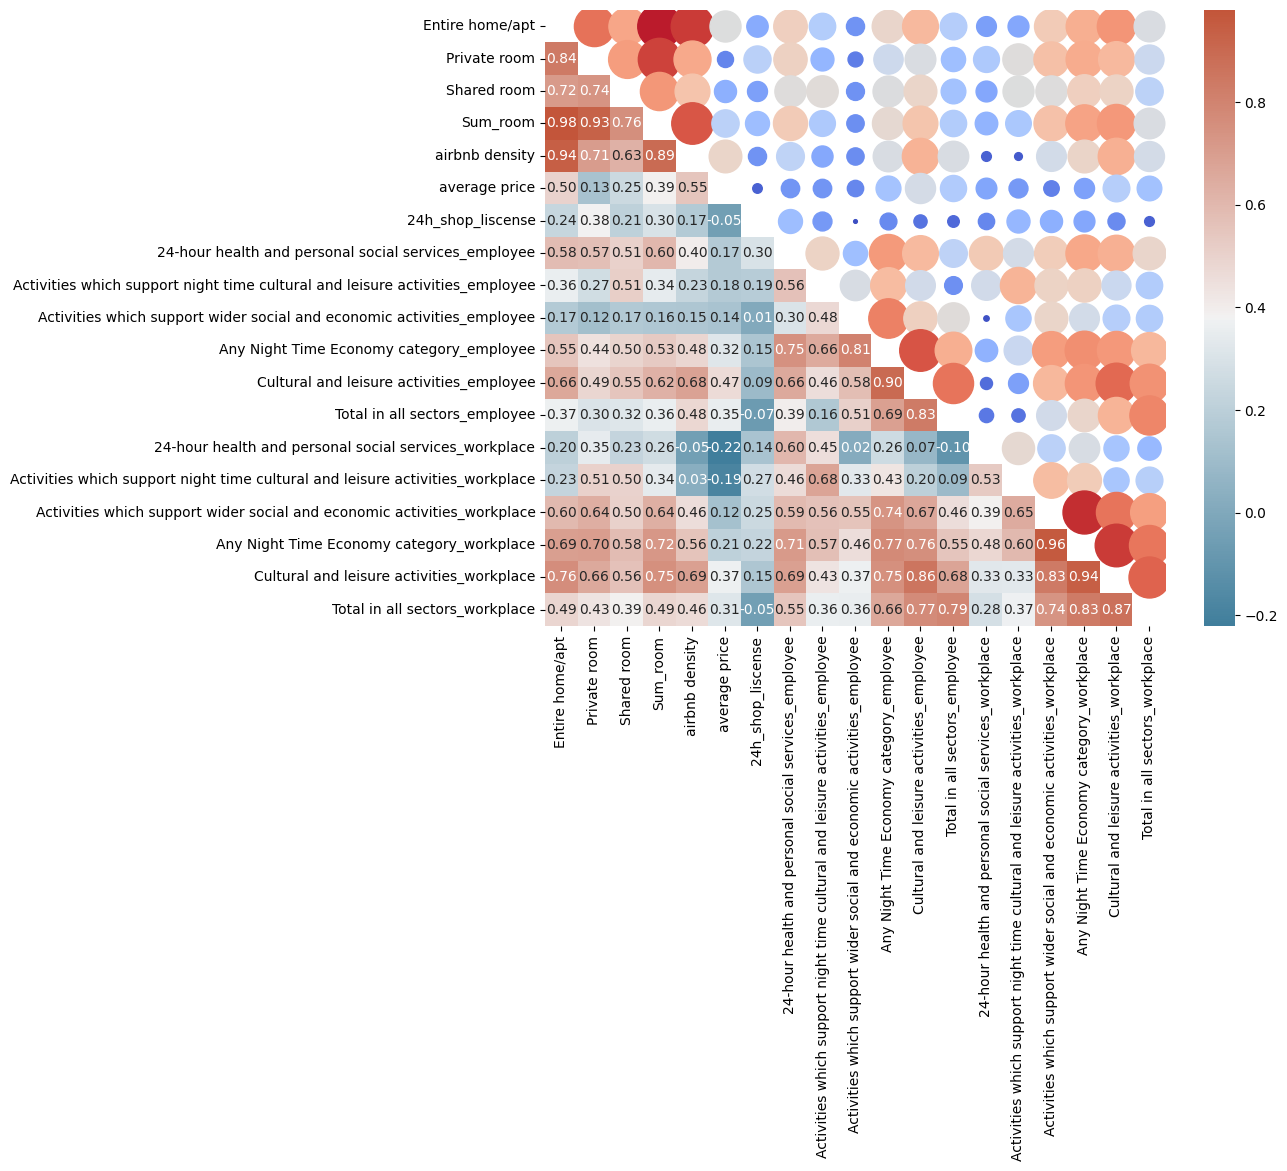

In [8]:
df_night_clean = df_night.dropna()
corr = df_night_clean[['Entire home/apt', 'Private room', 'Shared room', 'Sum_room', 'airbnb density',
                       'average price', '24h_shop_liscense', '24-hour health and personal social services_employee',
                       'Activities which support night time cultural and leisure activities_employee',
                       'Activities which support wider social and economic activities_employee',
                       'Any Night Time Economy category_employee', 'Cultural and leisure activities_employee',
                       'Total in all sectors_employee', '24-hour health and personal social services_workplace',
                       'Activities which support night time cultural and leisure activities_workplace',
                       'Activities which support wider social and economic activities_workplace',
                       'Any Night Time Economy category_workplace', 'Cultural and leisure activities_workplace',
                       'Total in all sectors_workplace']].corr()

# create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.triu(np.ones_like(corr, dtype=bool))

# create a custom diverging palette
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# draw the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, fmt=".2f")

# add circles with size and color proportional to the absolute correlation
for i in range(len(corr.columns)):
    for j in range(i):
        if not mask[i, j]:
            value = np.abs(corr.iloc[i, j])
            size = value * 1000  # Set the size based on the absolute correlation
            color = value  # Set the color based on the absolute correlation
            plt.scatter(i + 0.5, j + 0.5, s=size, c=color, cmap='coolwarm', marker='o', vmin=0, vmax=1)

plt.show()

### **Spatial Autocorrelation Analysis （Moran's I）**

Download the **shapfile** of London boroughs to add geo-information

In [9]:
geo_url = 'https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip'
response = requests.get(geo_url)

# create a temporary file folder
temp_folder = 'temp_geo_data'
os.makedirs(temp_folder, exist_ok=True)

# unzip files to the temporary file folder
with ZipFile(BytesIO(response.content)) as zip_file:
    zip_file.extractall(temp_folder)

all_files = []
for root, dirs, files in os.walk(temp_folder):
    for file in files:
        all_files.append(os.path.join(root, file))

# look for shapefile
shp_files = [file for file in all_files if file.endswith('.shp')]

# select shapefile
if shp_files:
    selected_shp_file = shp_files[0]
    gdf_boroughs = gpd.read_file(selected_shp_file)
    print(gdf_boroughs.head())
else:
    print("No SHP files found in the ZIP archive.")

# delete the temporary folder
shutil.rmtree(temp_folder)


                   NAME   GSS_CODE   HECTARES  NONLD_AREA ONS_INNER SUB_2009  \
0  Kingston upon Thames  E09000021   3726.117       0.000         F     None   
1               Croydon  E09000008   8649.441       0.000         F     None   
2               Bromley  E09000006  15013.487       0.000         F     None   
3              Hounslow  E09000018   5658.541      60.755         F     None   
4                Ealing  E09000009   5554.428       0.000         F     None   

  SUB_2006                                           geometry  
0     None  POLYGON ((516401.600 160201.800, 516407.300 16...  
1     None  POLYGON ((535009.200 159504.700, 535005.500 15...  
2     None  POLYGON ((540373.600 157530.400, 540361.200 15...  
3     None  POLYGON ((521975.800 178100.000, 521967.700 17...  
4     None  POLYGON ((510253.500 182881.600, 510249.900 18...  


Take the column 'Entire home/apt' as an example, do the **Moran's I and it's P value**  
Adding the results to dataframe

In [10]:
from libpysal.weights import Queen
from esda.moran import Moran_Local
df_with_location = pd.merge(df_night, gdf_boroughs, how='left', left_on='neighbourhood', right_on='NAME')

w = Queen.from_dataframe(gdf_boroughs)

variables = ['Entire home/apt']

for variable in variables:
    # 提取感兴趣的列
    data = df_with_location[['geometry', variable]]

    # 创建局部空间自相关对象
    moran_loc = Moran_Local(data[variable], w)

    # 将局部 Moran's I 的结果添加到 GeoDataFrame 中
    df_with_location[f'Local_Moran_{variable}'] = moran_loc.Is
    df_with_location[f'Local_Moran_P_{variable}'] = moran_loc.p_sim

df_with_location.head()


C:\Users\15827\AppData\Local\Temp\ipykernel_14764\3814754818.py:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_boroughs)


,neighbourhood,Entire home/apt,Hotel room,Private room,Shared room,average price,Sum_room,24h_shop_liscense,Area code,Area name_x,...,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,Local_Moran_Entire home/apt,Local_Moran_P_Entire home/apt
0,Barking and Dagenham,199,0,247,4,106.420000,450,1.0,E09000002,Barking and Dagenham,...,Barking and Dagenham,E09000002,3779.934,169.150,F,None,None,"MULTIPOLYGON (((543905.400 183199.100, 543905....",-0.569785,0.096
1,Barnet,914,1,762,12,147.647128,1689,0.0,E09000003,Barnet,...,Barnet,E09000003,8674.837,0.000,F,None,None,"POLYGON ((524579.900 198355.200, 524594.300 19...",0.077605,0.334
2,Bexley,140,0,206,3,90.762178,349,1.0,E09000004,Bexley,...,Bexley,E09000004,6428.649,370.619,F,None,None,"POLYGON ((547226.200 181299.300, 547320.900 18...",-0.049482,0.427
3,Brent,1220,0,995,8,208.811066,2223,34.0,E09000005,Brent,...,Brent,E09000005,4323.270,0.000,F,None,None,"POLYGON ((525201.000 182512.600, 525181.500 18...",-0.004795,0.362
4,Bromley,308,0,299,4,118.563011,611,8.0,E09000006,Bromley,...,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15...",0.278857,0.180


Transform the dataframe to **geodataframe**, and visualize the result on maps

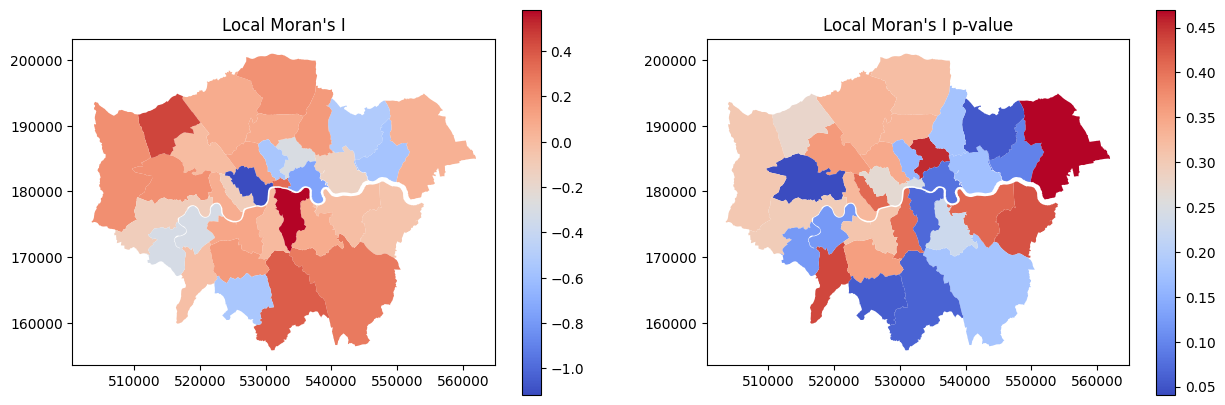

In [27]:
from shapely.geometry import Polygon, MultiPolygon

gdf_with_location = gpd.GeoDataFrame(df_with_location, geometry='geometry')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# 绘制局部 Moran's I 值
gdf_with_location.plot(column='Local_Moran_Entire home/apt', cmap='coolwarm', linewidth=0.8, ax=ax[0], legend=True)
ax[0].set_title('Local Moran\'s I')

# 绘制局部 Moran's I p 值
gdf_with_location.plot(column='Local_Moran_P_Entire home/apt', cmap='coolwarm', linewidth=0.8, ax=ax[1], legend=True)
ax[1].set_title('Local Moran\'s I p-value')

# 显示图形
plt.show()
